In [1]:
import gymnasium as gym
import numpy as np

In [2]:
n_states = 40
iter_max = 10000

initial_lr = 1.0 # Learning rate
min_lr = 0.003
gamma = 1.0
t_max = 10000
eps = 0.02

In [3]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

In [4]:
def obs_to_state(env, obs):
    """ Maps an observation to state """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b

In [5]:
def run_episode(env, policy=None, render=False):
    obs, _ = env.reset()  # Unpack the tuple returned by reset()
    total_reward = 0
    step_idx = 0
    for _ in range(t_max):
        if render:
            env.render()
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b = obs_to_state(env, obs)
            action = policy[a][b]
        obs, reward, done, _, _ = env.step(action)  # Unpack all 5 values from step()
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

In [6]:
# env.seed(0)
# np.random.seed(0)
print ('----- using Q Learning -----')
q_table = np.zeros((n_states, n_states, 3))
for i in range(iter_max):
    obs, _ = env.reset()  # Unpack the tuple returned by reset()
    # print(obs)
    total_reward = 0
    ## eta: learning rate is decreased at each step
    eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
    for j in range(t_max):
        a, b = obs_to_state(env, obs)
        if np.random.uniform(0, 1) < eps:
            action = np.random.choice(env.action_space.n)
        else:
            logits = q_table[a][b]
            logits_exp = np.exp(logits)
            probs = logits_exp / np.sum(logits_exp)
            action = np.random.choice(env.action_space.n, p=probs)
        obs, reward, done, _, _ = env.step(action)  # Unpack all 5 values from step()
        total_reward += reward
        # update q table
        a_, b_ = obs_to_state(env, obs)
        q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  np.max(q_table[a_][b_]) - q_table[a][b][action])
        if done:
            break
    if i % 100 == 0:
        print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
solution_policy = np.argmax(q_table, axis=2)
solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
print("Average score of solution = ", np.mean(solution_policy_scores))
# Animate it
run_episode(env, solution_policy, True)

----- using Q Learning -----
Iteration #1 -- Total reward = -6203.
Iteration #101 -- Total reward = -434.
Iteration #201 -- Total reward = -514.
Iteration #301 -- Total reward = -269.
Iteration #401 -- Total reward = -250.
Iteration #501 -- Total reward = -322.
Iteration #601 -- Total reward = -326.
Iteration #701 -- Total reward = -306.
Iteration #801 -- Total reward = -340.
Iteration #901 -- Total reward = -240.
Iteration #1001 -- Total reward = -240.
Iteration #1101 -- Total reward = -241.
Iteration #1201 -- Total reward = -285.
Iteration #1301 -- Total reward = -227.
Iteration #1401 -- Total reward = -238.
Iteration #1501 -- Total reward = -196.
Iteration #1601 -- Total reward = -126.
Iteration #1701 -- Total reward = -197.
Iteration #1801 -- Total reward = -154.
Iteration #1901 -- Total reward = -197.
Iteration #2001 -- Total reward = -164.
Iteration #2101 -- Total reward = -162.
Iteration #2201 -- Total reward = -166.
Iteration #2301 -- Total reward = -192.
Iteration #2401 -- Tot

/home/krish/dev/rl-exp/.venv/lib/python3.10/site-packages/gymnasium/envs/classic_control/mountain_car.py:178: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


-110.0

In [7]:
solution_policy

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(40, 40))

In [8]:
env_name = 'MountainCar-v0'
env = gym.make(env_name, render_mode="human")

In [9]:
# Test solution policy  
solution_scores = []

score = run_episode(env, policy=solution_policy, render=True)
print(f"Score: {score}")
solution_scores.append(score)

Score: -158.0


In [10]:
# # Demonstrate how the agent uses the solution policy
# print("=== SOLUTION POLICY USAGE DEMONSTRATION ===\n")

# # 1. Show the policy structure
# print(f"Solution policy shape: {solution_policy.shape}")
# print(f"Policy represents: {solution_policy.shape[0]} position states × {solution_policy.shape[1]} velocity states")
# print(f"Each cell contains the best action (0=Left, 1=No Action, 2=Right)\n")

# # 2. Test the policy with a few example states
# print("Testing policy with example states:")
# env_low = env.observation_space.low
# env_high = env.observation_space.high
# env_dx = (env_high - env_low) / n_states

# # Test a few specific states
# test_states = [
#     (0, 0),      # Bottom-left corner
#     (n_states//2, n_states//2),  # Middle
#     (n_states-1, n_states-1),    # Top-right corner
#     (0, n_states-1),             # Bottom-right
#     (n_states-1, 0)              # Top-left
# ]

# for pos_idx, vel_idx in test_states:
#     action = solution_policy[pos_idx, vel_idx]
#     pos_val = env_low[0] + pos_idx * env_dx[0]
#     vel_val = env_low[1] + vel_idx * env_dx[1]
#     action_name = ['Left', 'No Action', 'Right'][action]
#     print(f"  State (pos={pos_val:.2f}, vel={vel_val:.2f}) → Action {action} ({action_name})")

# print("\n" + "="*50)

# # 3. Compare random policy vs solution policy
# print("\n=== PERFORMANCE COMPARISON ===")

# # Test random policy
# random_scores = []
# for _ in range(10):
#     score = run_episode(env, policy=None, render=False)  # None = random policy
#     random_scores.append(score)

# # Test solution policy  
# solution_scores = []
# for _ in range(10):
#     score = run_episode(env, policy=solution_policy, render=False)
#     solution_scores.append(score)

# print(f"Random Policy Average Score: {np.mean(random_scores):.2f} ± {np.std(random_scores):.2f}")
# print(f"Solution Policy Average Score: {np.mean(solution_scores):.2f} ± {np.std(solution_scores):.2f}")
# print(f"Improvement: {np.mean(solution_scores) - np.mean(random_scores):.2f}")

# print("\n" + "="*50)

# 4. Show how the policy is used step-by-step
print("\n=== STEP-BY-STEP POLICY USAGE ===")
obs, _ = env.reset()
print(f"Initial observation: {obs}")

for step in range(5):  # Show first 5 steps
    a, b = obs_to_state(env, obs)
    action = solution_policy[a, b]
    action_name = ['Left', 'No Action', 'Right'][action]
    
    print(f"Step {step+1}:")
    print(f"  Observation: {obs}")
    print(f"  State indices: ({a}, {b})")
    print(f"  Policy action: {action} ({action_name})")
    
    obs, reward, done, _, _ = env.step(action)
    print(f"  Reward: {reward}, Done: {done}")
    
    if done:
        print("  Episode finished!")
        break
    print()



=== STEP-BY-STEP POLICY USAGE ===
Initial observation: [-0.50259304  0.        ]
Step 1:
  Observation: [-0.50259304  0.        ]
  State indices: (15, 20)
  Policy action: 0 (Left)
  Reward: -1.0, Done: False

Step 2:
  Observation: [-0.5037505  -0.00115744]
  State indices: (15, 19)
  Policy action: 0 (Left)
  Reward: -1.0, Done: False

Step 3:
  Observation: [-0.5060567  -0.00230621]
  State indices: (15, 19)
  Policy action: 0 (Left)
  Reward: -1.0, Done: False

Step 4:
  Observation: [-0.5094944  -0.00343772]
  State indices: (15, 19)
  Policy action: 0 (Left)
  Reward: -1.0, Done: False

Step 5:
  Observation: [-0.5140379  -0.00454347]
  State indices: (15, 18)
  Policy action: 0 (Left)
  Reward: -1.0, Done: False



In [ ]:
# Save and load the solution policy for future use
import pickle
import os

# Save the Q-table and policy
policy_data = {
    'q_table': q_table,
    'solution_policy': solution_policy,
    'n_states': n_states,
    'env_name': env_name,
    'env_low': env.observation_space.low,
    'env_high': env.observation_space.high
}

# Save to file
with open('mountain_car_Q_learning_policy.pkl', 'wb') as f:
    pickle.dump(policy_data, f)

print("✅ Policy saved to 'mountain_car_policy.pkl'")

# Function to load and use a saved policy
def load_and_test_policy(filename='mountain_car_policy.pkl'):
    """Load a saved policy and test it"""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    # Create environment
    test_env = gym.make(data['env_name'])
    
    # Load policy
    loaded_policy = data['solution_policy']
    
    # Test the loaded policy
    scores = []
    for _ in range(5):
        score = run_episode(test_env, loaded_policy, render=False)
        scores.append(score)
    
    print(f"Loaded policy average score: {np.mean(scores):.2f} ± {np.std(scores):.2f}")
    return loaded_policy

# Test loading the policy
print("\n=== TESTING LOADED POLICY ===")
loaded_policy = load_and_test_policy()

print("\n=== HOW TO USE THE POLICY IN YOUR CODE ===")
print("""
# Method 1: Use the policy directly
action = solution_policy[state_pos, state_vel]

# Method 2: Load from file
with open('mountain_car_policy.pkl', 'rb') as f:
    data = pickle.load(f)
policy = data['solution_policy']

# Method 3: Use in run_episode function
score = run_episode(env, solution_policy, render=True)  # render=True to see animation
""")


✅ Policy saved to 'mountain_car_policy.pkl'

=== TESTING LOADED POLICY ===
Loaded policy average score: -125.80 ± 32.60

=== HOW TO USE THE POLICY IN YOUR CODE ===

# Method 1: Use the policy directly
action = solution_policy[state_pos, state_vel]

# Method 2: Load from file
with open('mountain_car_policy.pkl', 'rb') as f:
    data = pickle.load(f)
policy = data['solution_policy']

# Method 3: Use in run_episode function
score = run_episode(env, solution_policy, render=True)  # render=True to see animation



: 

<Axes: >

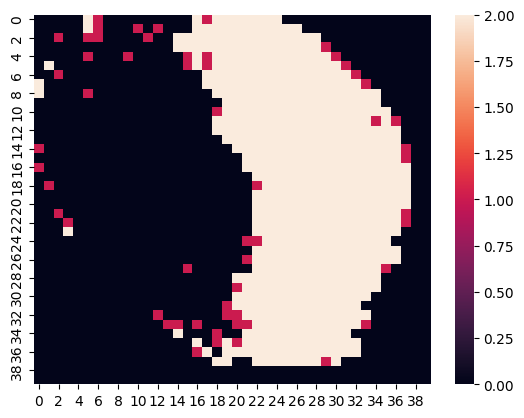

In [12]:
import seaborn as sns

sns.heatmap(solution_policy)

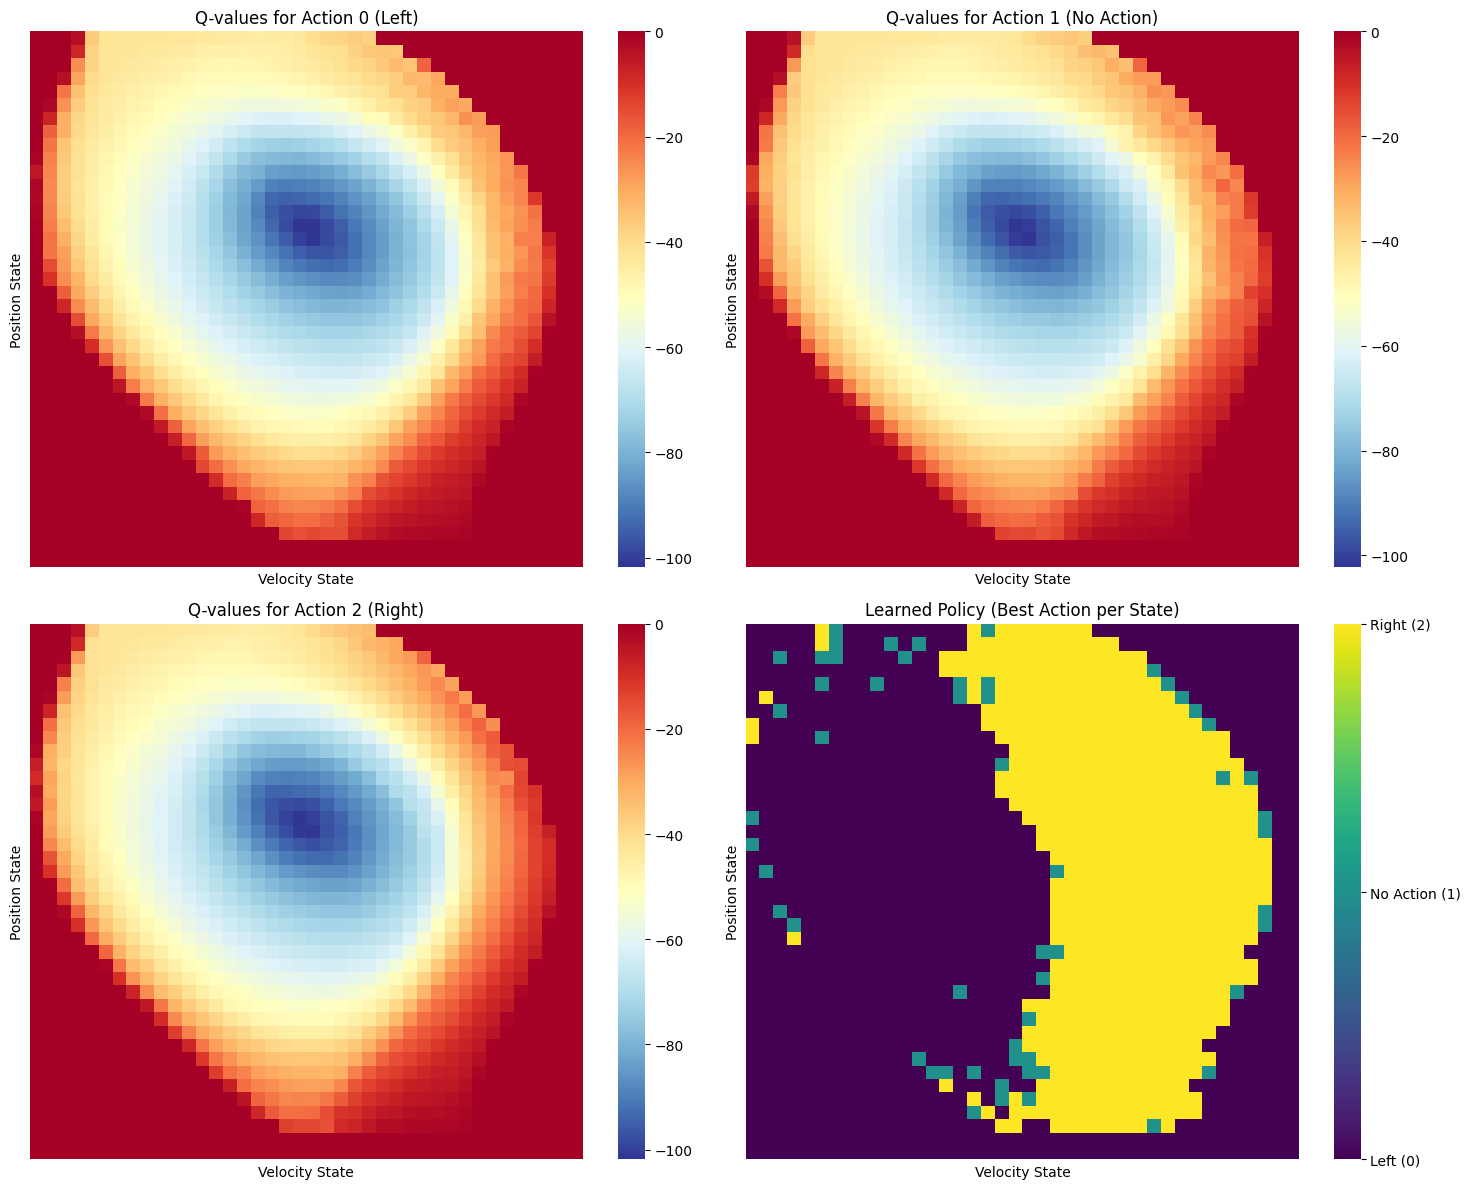

Q-table shape: (40, 40, 3)
Policy shape: (40, 40)
Action distribution in policy:
  Action 0 (Left (0)): 982 states (61.4%)
  Action 1 (No Action (1)): 56 states (3.5%)
  Action 2 (Right (2)): 562 states (35.1%)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations of the Q-table
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Get the learned policy (argmax actions)
policy = np.argmax(q_table, axis=2)

# Action names for MountainCar-v0
action_names = ['Left (0)', 'No Action (1)', 'Right (2)']

# 1. Q-values for Action 0 (Left)
sns.heatmap(q_table[:, :, 0], ax=axes[0, 0], cmap='RdYlBu_r', 
            xticklabels=False, yticklabels=False, cbar=True)
axes[0, 0].set_title('Q-values for Action 0 (Left)')
axes[0, 0].set_xlabel('Velocity State')
axes[0, 0].set_ylabel('Position State')

# 2. Q-values for Action 1 (No Action)
sns.heatmap(q_table[:, :, 1], ax=axes[0, 1], cmap='RdYlBu_r', 
            xticklabels=False, yticklabels=False, cbar=True)
axes[0, 1].set_title('Q-values for Action 1 (No Action)')
axes[0, 1].set_xlabel('Velocity State')
axes[0, 1].set_ylabel('Position State')

# 3. Q-values for Action 2 (Right)
sns.heatmap(q_table[:, :, 2], ax=axes[1, 0], cmap='RdYlBu_r', 
            xticklabels=False, yticklabels=False, cbar=True)
axes[1, 0].set_title('Q-values for Action 2 (Right)')
axes[1, 0].set_xlabel('Velocity State')
axes[1, 0].set_ylabel('Position State')

# 4. Learned Policy (argmax actions)
policy_plot = sns.heatmap(policy, ax=axes[1, 1], cmap='viridis', 
                         xticklabels=False, yticklabels=False, cbar=True)
axes[1, 1].set_title('Learned Policy (Best Action per State)')
axes[1, 1].set_xlabel('Velocity State')
axes[1, 1].set_ylabel('Position State')

# Add colorbar labels for policy
cbar = axes[1, 1].collections[0].colorbar
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(action_names)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Q-table shape: {q_table.shape}")
print(f"Policy shape: {policy.shape}")
print(f"Action distribution in policy:")
unique, counts = np.unique(policy, return_counts=True)
for action, count in zip(unique, counts):
    print(f"  Action {action} ({action_names[action]}): {count} states ({count/(policy.size)*100:.1f}%)")


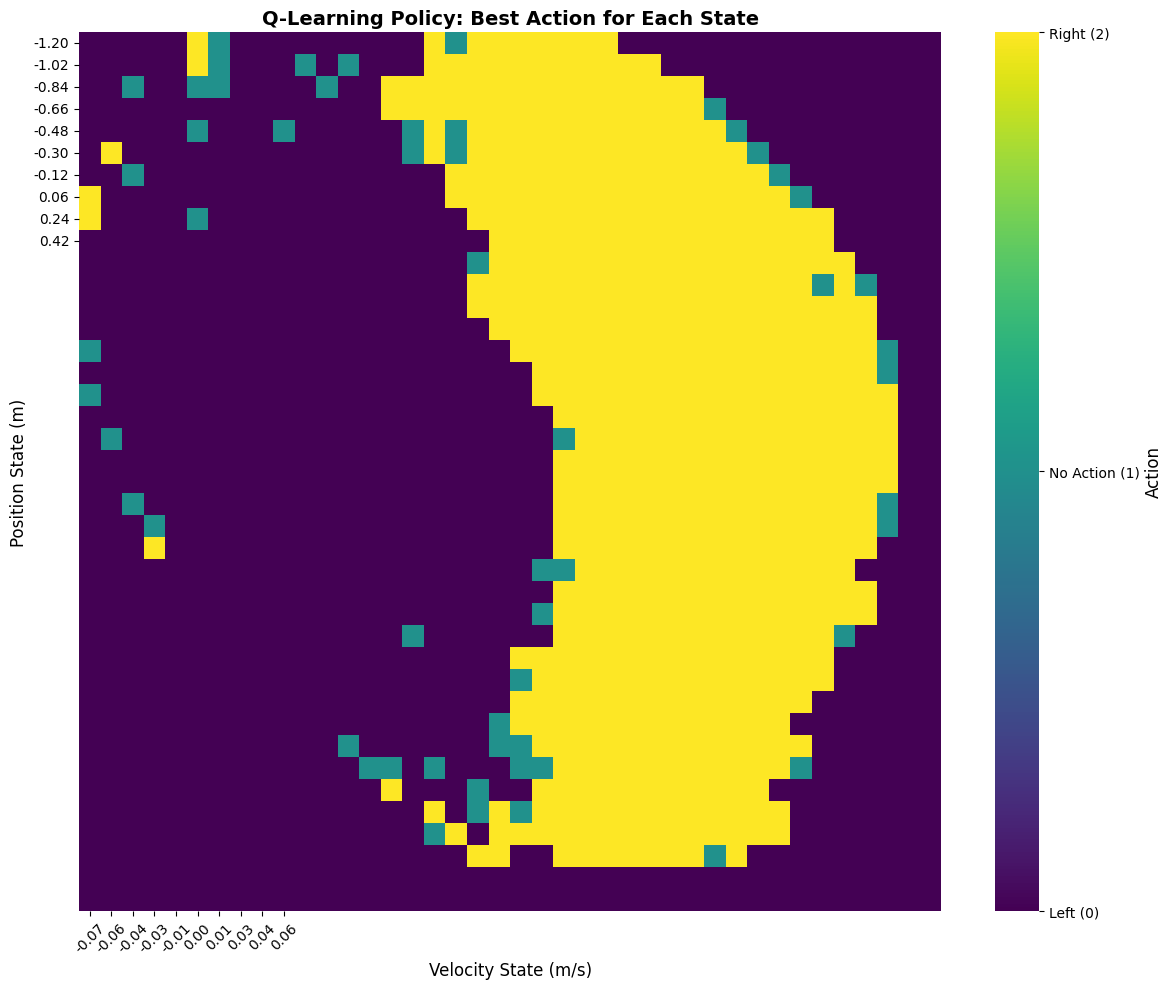


Q-value Statistics:
Min Q-value: -102.1880
Max Q-value: 0.0000
Mean Q-value: -33.1468
Std Q-value: 28.9928

Policy Statistics:
Total states: 1600
Action 0 (Left (0)): 982 states (61.4%)
Action 1 (No Action (1)): 56 states (3.5%)
Action 2 (Right (2)): 562 states (35.1%)


In [14]:
# Create a more detailed confusion matrix with state labelsb 
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Create state labels for better understanding
env_low = env.observation_space.low
env_high = env.observation_space.high
env_dx = (env_high - env_low) / n_states

# Generate position and velocity labels
position_labels = [f"{env_low[0] + i * env_dx[0]:.2f}" for i in range(n_states)]
velocity_labels = [f"{env_low[1] + i * env_dx[1]:.2f}" for i in range(n_states)]

# Create the policy heatmap with labels
policy_heatmap = sns.heatmap(policy, 
                            xticklabels=velocity_labels[::4],  # Show every 4th label for readability
                            yticklabels=position_labels[::4],  # Show every 4th label for readability
                            cmap='viridis',
                            cbar=True,
                            ax=ax)

ax.set_title('Q-Learning Policy: Best Action for Each State', fontsize=14, fontweight='bold')
ax.set_xlabel('Velocity State (m/s)', fontsize=12)
ax.set_ylabel('Position State (m)', fontsize=12)

# Customize colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Left (0)', 'No Action (1)', 'Right (2)'])
cbar.set_label('Action', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Print Q-value statistics
print("\nQ-value Statistics:")
print(f"Min Q-value: {q_table.min():.4f}")
print(f"Max Q-value: {q_table.max():.4f}")
print(f"Mean Q-value: {q_table.mean():.4f}")
print(f"Std Q-value: {q_table.std():.4f}")

# Print policy statistics
print(f"\nPolicy Statistics:")
print(f"Total states: {policy.size}")
for action in range(3):
    count = np.sum(policy == action)
    percentage = (count / policy.size) * 100
    print(f"Action {action} ({action_names[action]}): {count} states ({percentage:.1f}%)")


In [15]:
q_table

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.00796575],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.17513846, -0.07904348, -0.42645364],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0